# Option pricing with Monte Carlo methods

The main purpose of this notebook is to explore more about Monte Carlo Methods for option pricing. The famous Black Scholes model is a closed form solution for the price of an option, which while easy to implment, and computationally inexpensive, is much less vertatile compared to Monte Carlo Methods.

The purpose of this notebook is to explore how to use Monte Carlo Methods to value different types of options.

To begin, we will start with the most simple example, which would be to compare the MC method to the Black and Scholes Result


For some brief introduction:

The Stochastic process $S_t$ is said to follow Geometric Brownian motion if it follows the SDE below

$$
dS_t = \mu S_t dt +  \sigma S_t dW_t\,.
$$

The solution to this SDE is

$$
S_t = S_0 * exp ((\mu - \sigma^2/2)t + \sigma W_t)))
$$

Let us begin by using Monte Carlo methods to estimate the value of an option under the GBM equations above



We can estimate this directly via the Euler-Maruyama method (i.e. typical Euler method where we calculate the value in discrete steps, where we utilize the derivative multiplied by the distance, but add a 'shock' or the contribution of $\sigma$)

I.e. If we divide the total time horizon $T$ into $N$ steps, can define $\Delta t T/N$

We can define

$S_{n+1} = S_n + \mu S_n \Delta t + \sigma S_n \epsilon \sqrt{\Delta t} = S_n (1 + \mu\Delta t+ \sigma\epsilon\sqrt{\Delta t})$

where $\epsilon \sim N(0,1)$ '


The function that does this is below

In [92]:
#mu, sigma: mu and sigma from formula
#T = total time to option expiry
#NumInterval = number of intervals in the discretization of T into chunks
#NumTrial = number of trials in the simulation, # of chains
#S0 = starting price of S

def MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0):
    dt = T/NumInt
    S_mat = np.zeros((NumInt + 1, NumTrial))
    
    #init starting value = 100
    S_mat[0] = S0
    
    #standard normal vector, size NumInt
    normalvec = np.random.normal(0,1,(NumInt,NumTrial))

    #follow formula above
    for t in range(1,M+1):
        S_mat[t] = normalvec[t-1] * sigma * np.sqrt(dt)
        S_mat[t] += (1 + mu * dt)
        S_mat[t] *= S_mat[t-1]
    return S_mat

We can test the result below, for 100 intervals and 1000 different trial / realizations of the simulation

In [138]:
mu = 0.05
sigma = 0.4
T = 1
NumInterval = 100
NumTrial = 1000
S0 = 100
S = MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0)

We can see from the plot below what each trial looks like (for first 10 realizations), it visually appears to follow the GBM

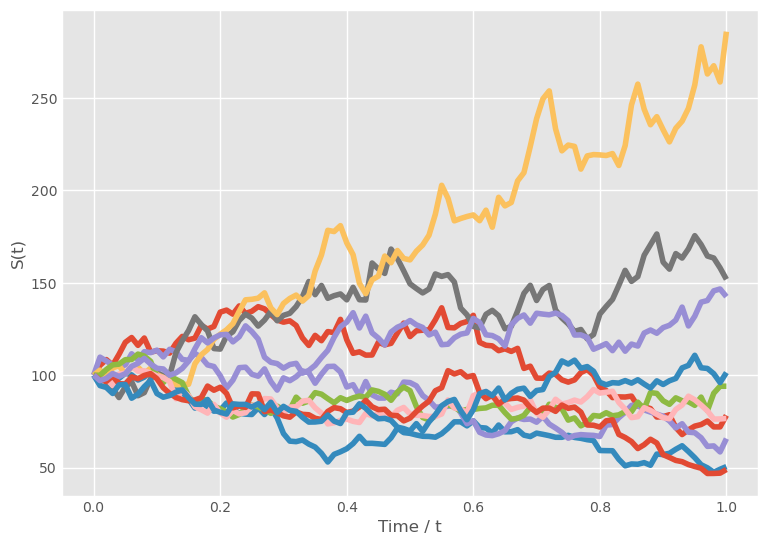

In [127]:
import matplotlib.pyplot as plt

#set x axis to time value)
dt = T/NumInterval
x_time = np.arange(0,T+dt*0.1,dt)

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.plot(x_time,(S[:, :10]))
plt.xlabel('Time / t')
plt.ylabel('S(t)')
plt.show()

To check if the desired result makes sense, we can also check the distribution of the final values

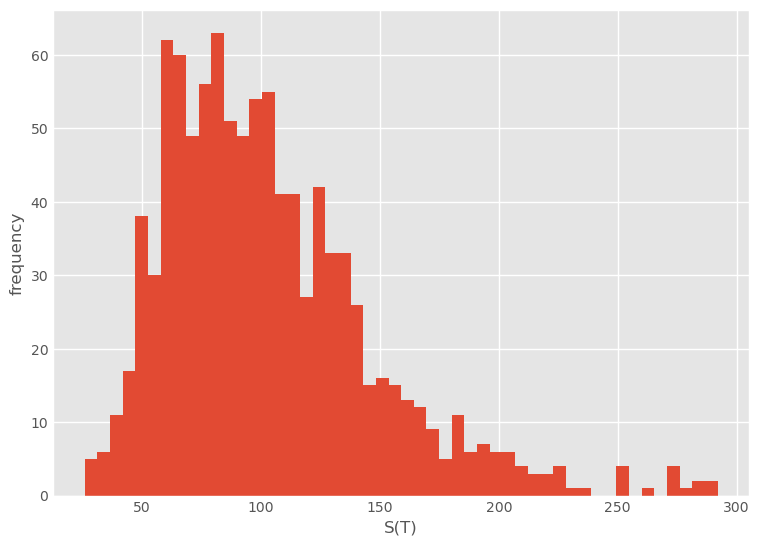

In [129]:
plt.figure(figsize=(8,6))
plt.hist(S[-1], bins=50)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()


We see that the distribution is log normal, albeit a bit chunky due to the number of sample points. We can run it agian, with more points to check if this resolves.

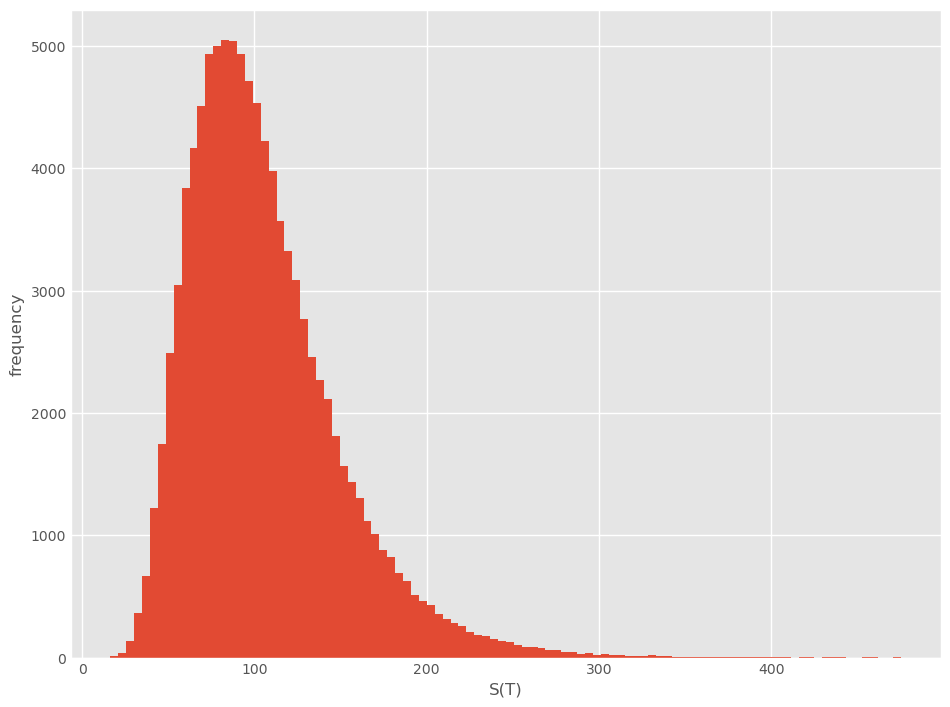

In [139]:
NumTrial = 100000
S = MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0)

plt.figure(figsize=(10, 8))
plt.hist(S[-1], bins=100)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()


As expected, the distribution tends closer to the log normal

Next step is to map this stock value to the value of the option. Lets consider a call option with strike price $K$. 
The payoff is $$\
p(S_{T}) = \max \left( S_{T}-K,0\right)\,.
$$

We can directly calculate the value of the option at time t and expiry T, by calculating all of the paths as in the steps before, calculating the payoff, taking the mean payoff, and discounting it back. Illustrated below:

Note here we are assuming we discount at same rate as $\mu$ (i.e. $\mu =$ risk free rate)

In [222]:
def MonteCarloCallOption(S_t, Strike, mu, sigma, T, t, NumInterval, NumTrial):
    #Monte Carlo Simulation of the paths
    S = MonteCarloGBM(mu, sigma, T-t, NumInterval, NumTrial, S_t)

    #calculate payoff
    finalS = S[-1]
    finalS -= Strike
    finalS[finalS<0] = 0
    
    return (np.mean(finalS)*np.e**(-mu*(T-t)))

In [226]:
t = 0
K = 90
NumTrial = 100000
S_t = S0
value = MonteCarloCallOption(S_t, K, mu, sigma, T, t, NumInterval, NumTrial)
print('Value of Call Option is:', value)

Value of Call Option is: 19.76399435076234


Now we can directly compare this to Black Scholes model, to check if our methodology is correct!


The formula for the analytical solution of the Black-Scholes equation for an european call option is:
$$
C(S,t) = S\, N(d_{1}) - K\,e^{-r(T-t)}N(d_{2})\,,
$$
where:
$$
d_{1} = \frac{\ln(S/X) + \left(r + \frac{\sigma^{2}}{2}\right)\left(T-t\right)}{\sigma\sqrt{T-t}}\,,
$$
$$
d_{2} = d1 - \sigma\sqrt{T-t}
$$
and where $N(x)$ is the cumulative normal distribution:
$$
N(x)= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x} \; e^{-t^{2}/2} dt,.
$$

We can quickly write a function to calculate these values below:

In [227]:
from scipy import stats
def BlackScholesCallValue(S_t,K,mu,sigma,T,t):
    
    d1 = (np.log(S_t/K)+(r+((sigma**2)/2))*(T-t))
    d1 /=(sigma*np.sqrt((T-t)))
    
    d2 = d1-sigma*np.sqrt((T-t))
    
    return S_t*stats.norm.cdf(d1) - K*np.exp(-r*(T-t))*stats.norm.cdf(d2)

Now we can directly compare the two

In [229]:
NumTrial = 1000000
value = MonteCarloCallOption(S_t, X, mu, sigma, T, t, NumInterval, NumTrial)
print('Value of Call Option via Monte Carlo is:', value)

valueBS = BlackScholesCallValue(S_t, X, mu, sigma, T, t)
print('Value of Call Option via Black Scholes is:', valueBS)

Value of Call Option via Monte Carlo is: 19.68388980028747
Value of Call Option via Black Scholes is: 19.69744208683972


Here, we see the result is extremely similar, which we would expect given the equivalence of these two methods

# Exotic Options

Now that we have tested how to use Monte Carlo simulation to price a standard European option modelled by the Black Scholes model, we will now move on to move complicated option types, ones that we cannot analytically solve like in the BS model